<a href="https://colab.research.google.com/github/titobi/Brain-Tumor-Image-Classfication/blob/main/Brain_Tumor_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip uninstall -y tensorflow keras tf-keras

!pip install tensorflow==2.15 keras==2.15

# Import necessary libraries
import os,glob,sys
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn import model_selection, metrics, preprocessing
from tqdm import tqdm
import pandas as pd
from keras.utils import to_categorical
from keras.applications.resnet import ResNet50

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)


In [2]:
#mount and unzip the file from google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


!unzip "/content/drive/MyDrive/Brain_MRI.zip" -d "/content/drive/MyDrive/imgs/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-g

In [3]:
# Define the paths for the testing and training datasets
test_path = "/content/drive/MyDrive/imgs/Testing/"
train_path = "/content/drive/MyDrive/imgs/Training/"

In [4]:
# Function to assign label to each image
def assign_label(img, tumor_type):
    return tumor_type
size = (224,224)

# Function to preprocess images and store data and labels
def make_data(tumor_type, dir, X, y):
    for img in tqdm(os.listdir(dir)):
        label = assign_label(img, tumor_type)
        path = os.path.join(dir, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size))
        X.append(np.array(img))
        y.append(str(label))
    return X, y


In [5]:
# Define the path for each class in the training dataset
X_train = []
y_train = []

pituitary_train = "/content/drive/MyDrive/imgs/Training/pituitary/"
notumor_train = "/content/drive/MyDrive/imgs/Training/notumor/"
meningioma_train = "/content/drive/MyDrive/imgs/Training/meningioma/"
glioma_train = "/content/drive/MyDrive/imgs/Training/glioma/"


In [6]:
# Define the path for each class in the test dataset
X_test = []
y_test = []

pituitary_test = "/content/drive/MyDrive/imgs/Testing/pituitary/"
notumor_test = "/content/drive/MyDrive/imgs/Testing/notumor/"
meningioma_test = "/content/drive/MyDrive/imgs/Testing/meningioma/"
glioma_test = "/content/drive/MyDrive/imgs/Testing/glioma/"

In [7]:
# Preprocess training images and store data and labels
X_train, y_train = make_data('Glioma', glioma_train, X_train, y_train)
X_train, y_train = make_data('Meningioma', meningioma_train, X_train, y_train)
X_train, y_train = make_data('Notumor', notumor_train, X_train, y_train)
X_train, y_train = make_data('Pituitary', pituitary_train, X_train, y_train)



100%|██████████| 1457/1457 [00:16<00:00, 89.97it/s] 


In [8]:
# Preprocess test images and store data and labels
X_test, y_test = make_data('Glioma', glioma_test, X_test, y_test)
X_test, y_test = make_data('Meningioma', meningioma_test, X_test, y_test)
X_test, y_test = make_data('Notumor', notumor_test, X_test, y_test)
X_test, y_test = make_data('Pituitary', pituitary_test, X_test, y_test)

100%|██████████| 300/300 [00:01<00:00, 151.66it/s]


In [9]:
# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize image data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes=len(np.unique(y_train)))

y_test = le.transform(y_test)
y_test = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Check the new shapes
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (5712, 224, 224, 3)
Test data shape: (1311, 224, 224, 3)


In [11]:
#print out the shape
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (5712, 224, 224, 3)
Training labels shape: (5712, 4)
Test data shape: (1311, 224, 224, 3)
Test labels shape: (1311, 4)


In [12]:
# Function to visualize sample images in the dataset
def show_sample_images(X, y, class_names, num_samples=3):
  plt.figure(figsize=(15, 10))
  for i, class_name in enumerate(class_names):
        class_indices = np.where(np.argmax(y, axis=1) == i)[0]
        sample_indices = class_indices[:num_samples]
        for j, idx in enumerate(sample_indices):
            img = X[idx]
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img, cmap='gray')
            plt.title(class_name)
            plt.axis('off')
  plt.show()

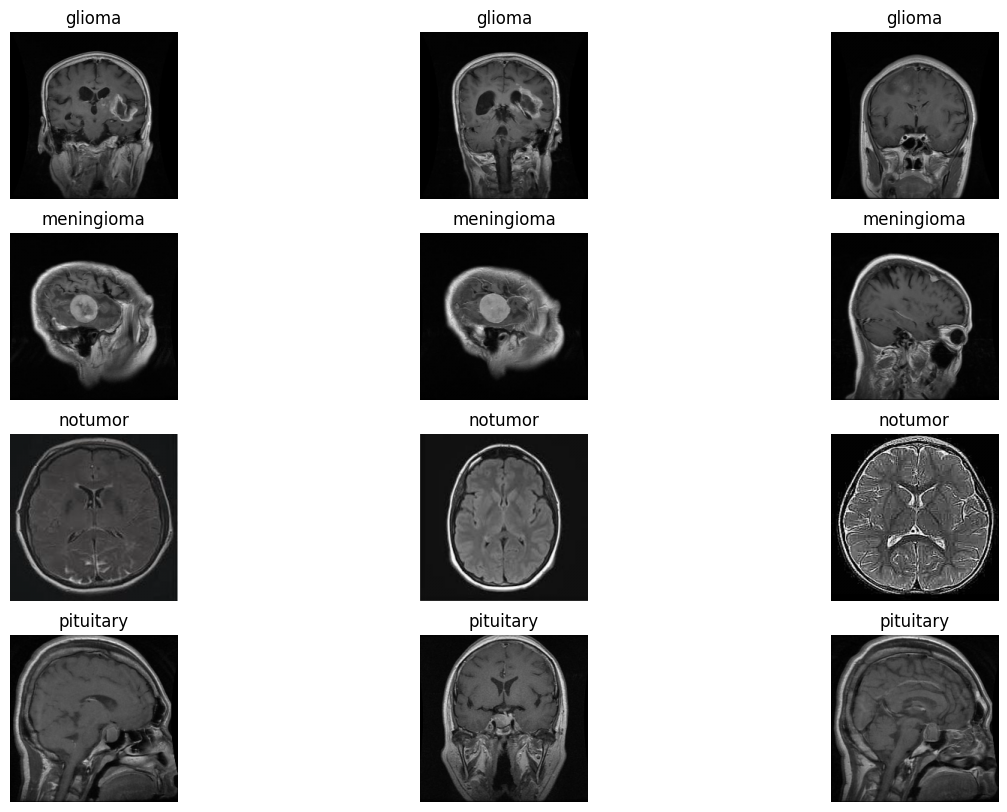

In [13]:
# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Visualize training data
show_sample_images(X_train, y_train, class_names)


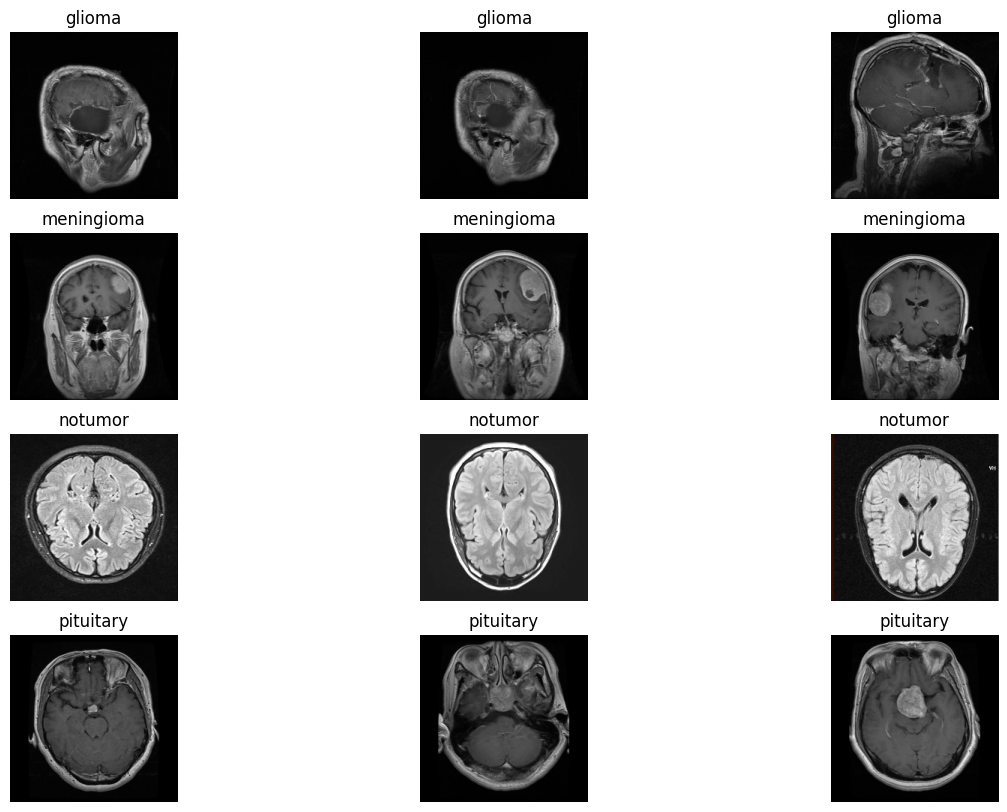

In [14]:
# Visualize test data
show_sample_images(X_test, y_test, class_names)

In [15]:
#Check the number of images in each class
def images_in_classes(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

train_count = images_in_classes(train_path)
test_count = images_in_classes(test_path)
print("Training class counts:", train_count)
print("Testing class counts:", test_count)

Training class counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing class counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


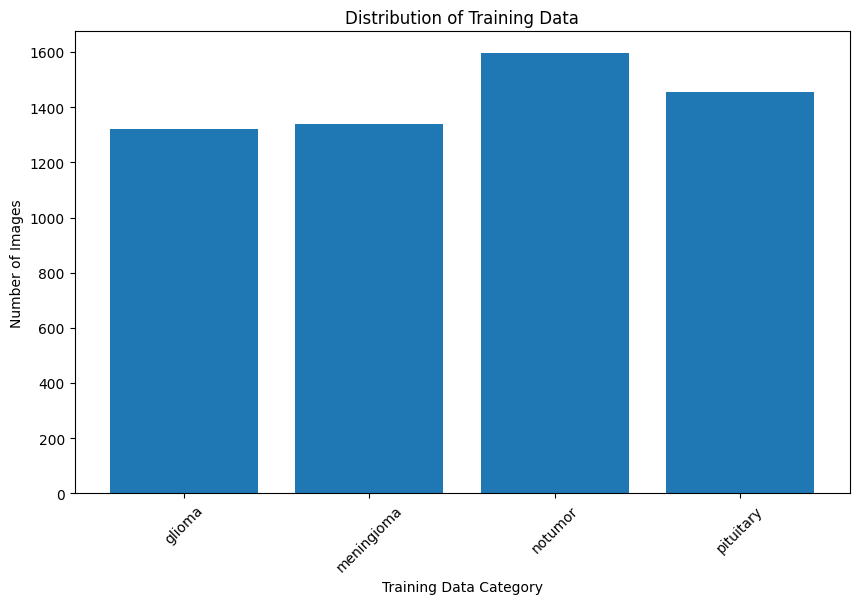

In [16]:
 # Create a bar chart showing the distribution of Train data
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Training Data Category')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show
plot_class_distribution(train_count, 'Distribution of Training Data')




In [17]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the images with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Create generators to load and preprocess the images
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size= size,
    batch_size=32,
    class_mode='categorical',

)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size= size,
    batch_size=32,
    class_mode='categorical',

)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [19]:
# Print class indices
print("Train classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)

#verify images and labels are loaded correctly
images, labels = next(train_generator)
print("Batch shape:", images.shape, labels.shape)

Train classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Batch shape: (32, 224, 224, 3) (32, 4)


In [20]:

# Load the VGG16 model
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights='imagenet',
                                               input_shape=(224, 224, 3),
                                               pooling='avg')


58889256/58889256 [==============================] - 3s 0us/step


In [21]:
# Define the model
model = Sequential()
model.add(base_model)


model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))  # Added dropout for regularization
model.add(Dense(4, activation='softmax'))

# Freeze the base model
base_model.trainable = False


In [22]:
# Compile the model

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 14879428 (56.76 MB)
Trainable params: 164740 (643.52 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [23]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output_shape)

X_train shape: (5712, 224, 224, 3)
y_train shape: (5712, 4)
Model output shape: (None, 4)


In [24]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
179/179 [==============================] - 48s 214ms/step - loss: 1.2838 - accuracy: 0.4347 - val_loss: 1.1302 - val_accuracy: 0.6491
Epoch 2/10
179/179 [==============================] - 27s 151ms/step - loss: 0.9958 - accuracy: 0.6495 - val_loss: 0.8936 - val_accuracy: 0.7155
Epoch 3/10
179/179 [==============================] - 29s 160ms/step - loss: 0.7977 - accuracy: 0.7269 - val_loss: 0.7681 - val_accuracy: 0.7368
Epoch 4/10
179/179 [==============================] - 28s 159ms/step - loss: 0.6648 - accuracy: 0.7733 - val_loss: 0.6894 - val_accuracy: 0.7712
Epoch 5/10
179/179 [==============================] - 28s 156ms/step - loss: 0.5972 - accuracy: 0.7962 - val_loss: 0.6427 - val_accuracy: 0.7757
Epoch 6/10
179/179 [==============================] - 28s 158ms/step - loss: 0.5430 - accuracy: 0.8129 - val_loss: 0.6004 - val_accuracy: 0.7918
Epoch 7/10
179/179 [==============================] - 28s 159ms/step - loss: 0.4965 - accuracy: 0.8291 - val_loss: 0.5731 - val_ac

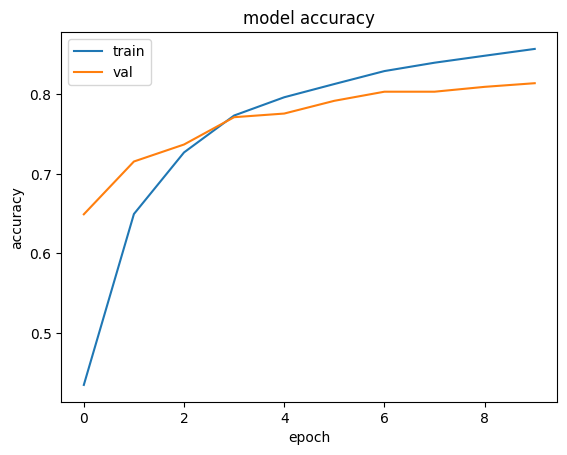

In [25]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

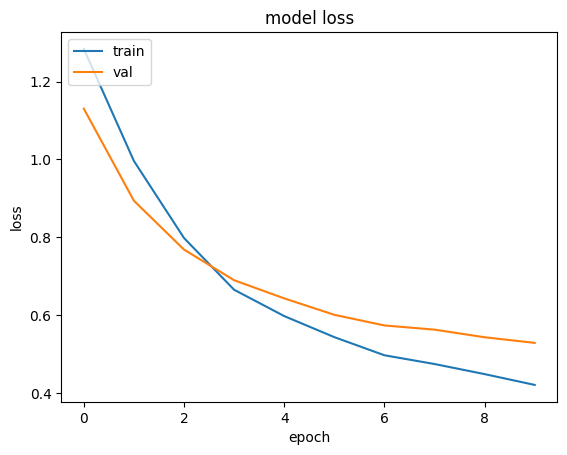

In [26]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


41/41 [==============================] - 6s 128ms/step - loss: 0.5355 - accuracy: 0.8078
Test loss: 0.5355433225631714
Test accuracy: 0.8077803254127502


In [28]:
# Plot confusion matrix of test data
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)



41/41 [==============================] - 5s 125ms/step
              precision    recall  f1-score   support

      glioma       0.83      0.76      0.79       300
  meningioma       0.73      0.54      0.62       306
     notumor       0.86      0.95      0.90       405
   pituitary       0.80      0.97      0.88       300

    accuracy                           0.81      1311
   macro avg       0.80      0.80      0.80      1311
weighted avg       0.81      0.81      0.80      1311

[[228  52   6  14]
 [ 34 164  55  53]
 [  9   6 384   6]
 [  5   2   2 291]]


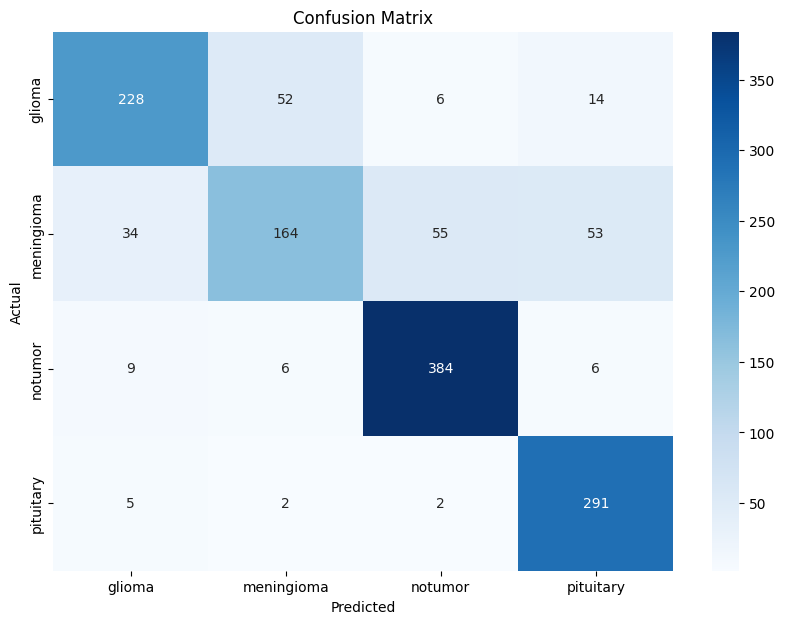

In [29]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [30]:
# Plot confusion matrix of train data
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Predict on the train set
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_train, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)


179/179 [==============================] - 23s 128ms/step
              precision    recall  f1-score   support

      glioma       0.86      0.84      0.85      1321
  meningioma       0.82      0.71      0.76      1339
     notumor       0.94      0.96      0.95      1595
   pituitary       0.86      0.96      0.91      1457

    accuracy                           0.88      5712
   macro avg       0.87      0.87      0.87      5712
weighted avg       0.87      0.88      0.87      5712

[[1115  150   21   35]
 [ 152  954   71  162]
 [  14   21 1534   26]
 [   9   34   11 1403]]


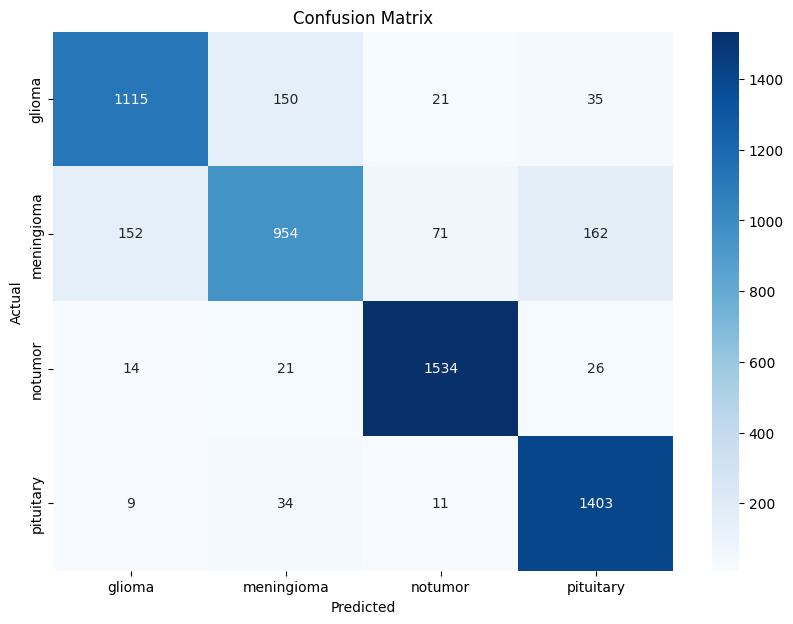

In [31]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [32]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the images with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
#Load the ResNet50 model
base_model = tf.keras.applications.resnet.ResNet50(include_top=False,
                                               weights='imagenet',
                                               input_shape=(224, 224, 3),
                                               pooling='avg')


94765736/94765736 [==============================] - 4s 0us/step


In [34]:
#Define the model
model = Sequential()
model.add(base_model)

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))   # Added dropout for regularization
model.add(Dense(4, activation='softmax'))  # Adjust the number of output classes

# Freeze the base model
base_model.trainable = False



In [35]:
# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [36]:
# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 24145668 (92.11 MB)
Trainable params: 55

In [37]:
# Train the model

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
179/179 [==============================] - 34s 153ms/step - loss: 1.4949 - accuracy: 0.3064 - val_loss: 1.2721 - val_accuracy: 0.3707
Epoch 2/20
179/179 [==============================] - 21s 118ms/step - loss: 1.2375 - accuracy: 0.4114 - val_loss: 1.1877 - val_accuracy: 0.5446
Epoch 3/20
179/179 [==============================] - 21s 116ms/step - loss: 1.1450 - accuracy: 0.4772 - val_loss: 1.1395 - val_accuracy: 0.5835
Epoch 4/20
179/179 [==============================] - 21s 116ms/step - loss: 1.0970 - accuracy: 0.5240 - val_loss: 1.0967 - val_accuracy: 0.5988
Epoch 5/20
179/179 [==============================] - 21s 117ms/step - loss: 1.0466 - accuracy: 0.5565 - val_loss: 1.0611 - val_accuracy: 0.6018
Epoch 6/20
179/179 [==============================] - 21s 116ms/step - loss: 0.9970 - accuracy: 0.6029 - val_loss: 1.0104 - val_accuracy: 0.6186
Epoch 7/20
179/179 [==============================] - 21s 116ms/step - loss: 0.9547 - accuracy: 0.6180 - val_loss: 0.9755 - val_ac

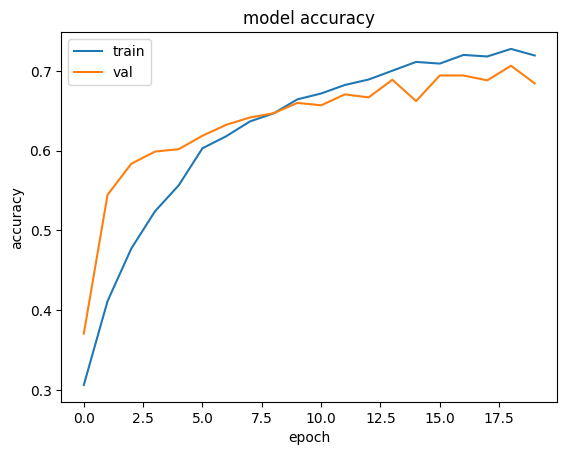

In [38]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

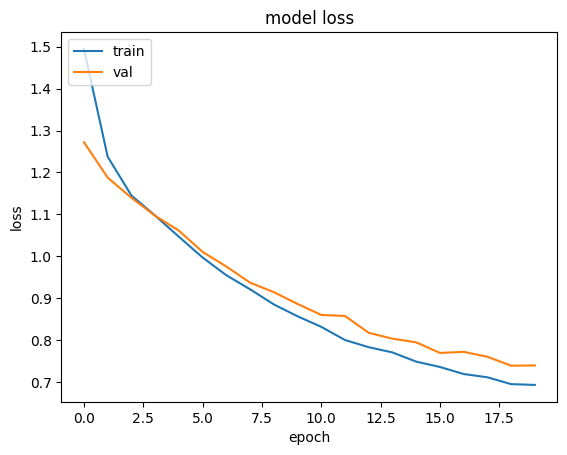

In [39]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


41/41 [==============================] - 6s 122ms/step - loss: 0.7205 - accuracy: 0.7018
Test loss: 0.7204718589782715
Test accuracy: 0.7017543911933899


In [41]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)



41/41 [==============================] - 5s 92ms/step
              precision    recall  f1-score   support

      glioma       0.63      0.61      0.62       300
  meningioma       0.51      0.46      0.48       306
     notumor       0.80      0.78      0.79       405
   pituitary       0.74      0.86      0.79       300

    accuracy                           0.68      1311
   macro avg       0.67      0.68      0.67      1311
weighted avg       0.68      0.68      0.68      1311

[[184  85   2  29]
 [ 51 141  75  39]
 [ 41  25 315  24]
 [ 15  28   0 257]]


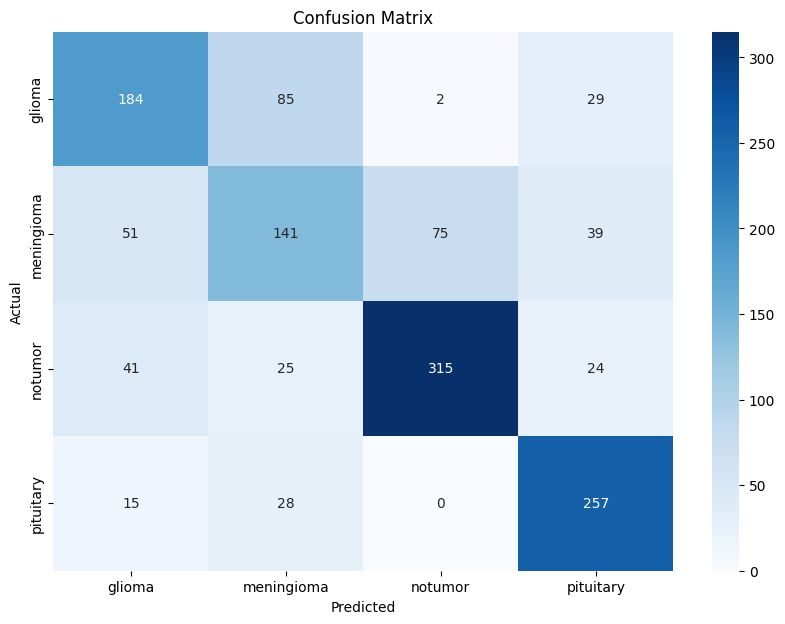

In [42]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [43]:
#Custom CNN Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


model = Sequential()
model.add(Conv2D(32, (3,3), activation= 'relu',input_shape=(224, 224, 3)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation= 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation= 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3), activation= 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())


model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Added dropout for regularization
model.add(Dense(4, activation='softmax'))

In [44]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the images with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [45]:
# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [46]:
# Display the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)       

In [47]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
179/179 [==============================] - 16s 68ms/step - loss: 0.8758 - accuracy: 0.6275 - val_loss: 0.7407 - val_accuracy: 0.7025
Epoch 2/10
179/179 [==============================] - 8s 47ms/step - loss: 0.5582 - accuracy: 0.7861 - val_loss: 0.5438 - val_accuracy: 0.7803
Epoch 3/10
179/179 [==============================] - 9s 48ms/step - loss: 0.4437 - accuracy: 0.8374 - val_loss: 0.4706 - val_accuracy: 0.8139
Epoch 4/10
179/179 [==============================] - 9s 48ms/step - loss: 0.3688 - accuracy: 0.8592 - val_loss: 0.4597 - val_accuracy: 0.8063
Epoch 5/10
179/179 [==============================] - 8s 47ms/step - loss: 0.3307 - accuracy: 0.8818 - val_loss: 0.3514 - val_accuracy: 0.8581
Epoch 6/10
179/179 [==============================] - 8s 47ms/step - loss: 0.2883 - accuracy: 0.8937 - val_loss: 0.3028 - val_accuracy: 0.8795
Epoch 7/10
179/179 [==============================] - 8s 47ms/step - loss: 0.2399 - accuracy: 0.9137 - val_loss: 0.2639 - val_accuracy: 0.909

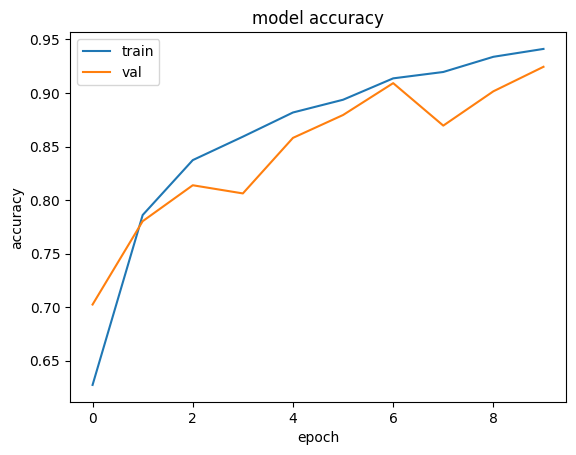

In [48]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

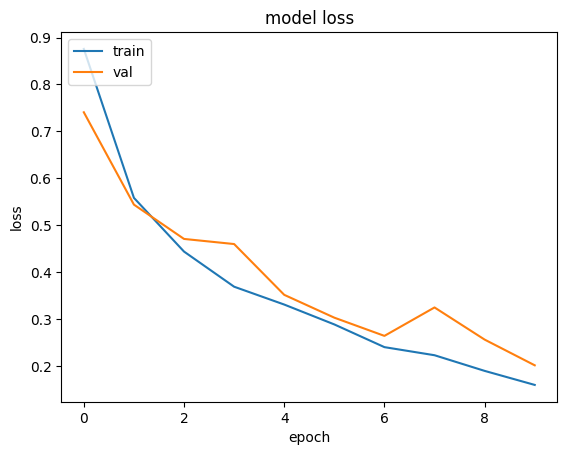

In [49]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)



41/41 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

      glioma       0.94      0.89      0.91       300
  meningioma       0.87      0.80      0.84       306
     notumor       0.92      0.99      0.95       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311

[[267  32   1   0]
 [ 16 246  36   8]
 [  2   2 401   0]
 [  0   2   0 298]]


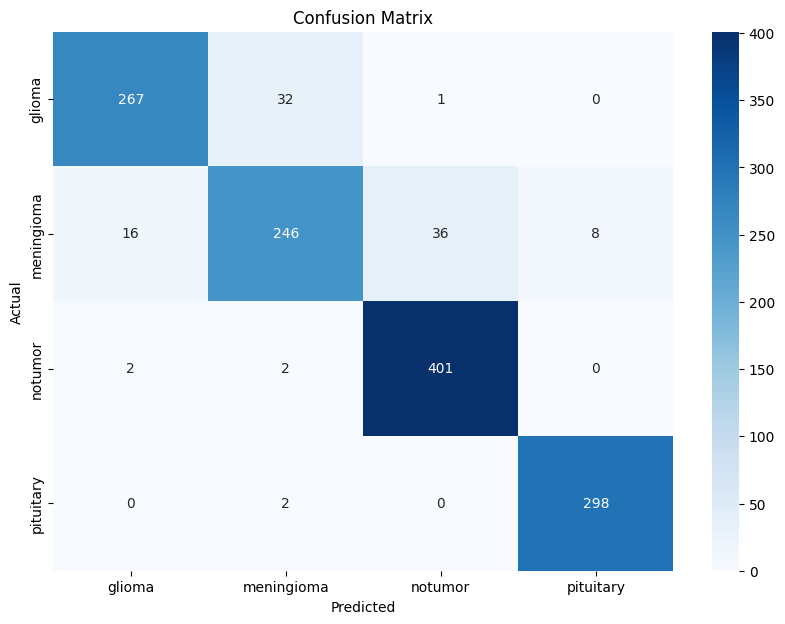

In [51]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
